In [29]:
import os
import glob
import shutil
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [7]:
# ---- CONFIG ----
REAL_ROOT = "data512"           # where your original REAL splits live
FAKE_SRC  = "Resized"           # folder with the 1110 fake 512x512 PNGs
OUT_ROOT  = "data512_balanced"  # new balanced dataset root
IMG_SIZE  = (512, 512)

splits = ["train", "val", "test"]


def list_images(folder):
    paths = []
    for ext in ("*.png", "*.jpg", "*.jpeg"):
        paths.extend(glob.glob(os.path.join(folder, ext)))
    return sorted(paths)


# ---- 1. Collect REAL image paths per split ----
real_paths = {}
min_real_per_split = float("inf")

for split in splits:
    real_dir = os.path.join(REAL_ROOT, split, "REAL")
    paths = list_images(real_dir)
    random.shuffle(paths)
    real_paths[split] = paths
    min_real_per_split = min(min_real_per_split, len(paths))
    print(f"{split}: {len(paths)} REAL images")

# ---- 2. Collect all FAKE images ----
fake_paths = list_images(FAKE_SRC)
random.shuffle(fake_paths)
n_fake_total = len(fake_paths)
print("Total FAKE images available:", n_fake_total)

# We want equal number per split (train/val/test)
fake_per_split = n_fake_total // len(splits)
# But we can't take more REALs than we have in the smallest split
N_PER_SPLIT = min(fake_per_split, min_real_per_split)

print(f"Using {N_PER_SPLIT} REAL and {N_PER_SPLIT} FAKE per split "
      f"({N_PER_SPLIT * len(splits)} total per class).")

# ---- 3. Helper to copy & resize ----
def copy_and_resize(src_paths, dst_dir, prefix):
    os.makedirs(dst_dir, exist_ok=True)
    for i, p in enumerate(src_paths):
        img = Image.open(p).convert("RGB")
        img = img.resize(IMG_SIZE, Image.BICUBIC)
        fname = f"{prefix}_{i:06d}.png"
        img.save(os.path.join(dst_dir, fname))


# ---- 4. Build balanced splits in OUT_ROOT ----
# Start index into fake_paths
fake_index = 0

# Clean OUT_ROOT if it already exists
if os.path.isdir(OUT_ROOT):
    shutil.rmtree(OUT_ROOT)

for split in splits:
    # REAL subset
    real_subset = real_paths[split][:N_PER_SPLIT]
    dst_real = os.path.join(OUT_ROOT, split, "REAL")
    copy_and_resize(real_subset, dst_real, "real")

    # FAKE subset
    fake_subset = fake_paths[fake_index:fake_index + N_PER_SPLIT]
    dst_fake = os.path.join(OUT_ROOT, split, "FAKE")
    copy_and_resize(fake_subset, dst_fake, "fake")

    fake_index += N_PER_SPLIT

    print(f"{split}: saved {N_PER_SPLIT} REAL + {N_PER_SPLIT} FAKE")


print("\nBalanced dataset created at:", OUT_ROOT)


train: 2100 REAL images
val: 600 REAL images
test: 300 REAL images
Total FAKE images available: 1110
Using 300 REAL and 300 FAKE per split (900 total per class).
train: saved 300 REAL + 300 FAKE
val: saved 300 REAL + 300 FAKE
test: saved 300 REAL + 300 FAKE

Balanced dataset created at: data512_balanced


In [ ]:
# ---------- CONFIG ----------
DATA_ROOT = "data512_balanced"
IMG_SIZE  = (512, 512)
BATCH_SIZE = 16          # 512x512 → keep this modest
SEED = 1
AUTOTUNE = tf.data.AUTOTUNE

# ---------- DATA LOADING ----------
# class_names fixes label order: 0 = FAKE, 1 = REAL
def make_ds(split, shuffle):
    return tf.keras.utils.image_dataset_from_directory(
        directory=os.path.join(DATA_ROOT, split),
        labels="inferred",
        label_mode="binary",
        class_names=["FAKE", "REAL"],
        image_size=IMG_SIZE,
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED,
    )

train_ds_raw = make_ds("train", shuffle=True)
val_ds_raw   = make_ds("val",   shuffle=False)
test_ds_raw  = make_ds("test",  shuffle=False)

# ---------- NORMALIZATION + PERFORMANCE PIPELINE ----------
normalizer = tf.keras.layers.Rescaling(1.0 / 255.0)

def add_normalization(ds):
    ds = ds.map(lambda x, y: (normalizer(x), y))
    ds = ds.cache().prefetch(AUTOTUNE)
    return ds

train_ds = add_normalization(train_ds_raw)
val_ds   = add_normalization(val_ds_raw)
test_ds  = add_normalization(test_ds_raw)

Found 600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [12]:
# EfficientNet-based REAL vs FAKE classifier for 512x512 images
def build_efficientnet_classifier(input_shape=(512, 512, 3), train_base=False):
    inputs = tf.keras.Input(shape=input_shape, name="input_image")

    # Our tf.data pipeline outputs images in [0,1]; EfficientNet expects 0–255 before preprocess_input.
    x = tf.keras.layers.Lambda(lambda img: preprocess_input(img * 255.0),
                               name="efficientnet_preprocess")(inputs)

    # Pretrained EfficientNet backbone
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=x,
        pooling="avg",          # global average pooling
    )
    base_model.trainable = train_base   # start frozen; we can unfreeze later to fine-tune

    # Classification head
    x = base_model.output
    x = tf.keras.layers.Dropout(0.3, name="dropout")(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="efficientnet_b0_real_fake")
    return model


model = build_efficientnet_classifier()
model.summary()

16705208/16705208 [==============================] - 14s 1us/step
Model: "efficientnet_b0_real_fake"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 efficientnet_preprocess (L  (None, 512, 512, 3)          0         ['input_image[0][0]']         
 ambda)                                                                                           
                                                                                                  
 rescaling_1 (Rescaling)     (None, 512, 512, 3)          0         ['efficientnet_preprocess[0][0
                                                                    ]']                           
        

In [13]:
# --- COMPILE ---

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

# --- TRAIN (phase 1: EfficientNet frozen, head only) ---

EPOCHS = 15  # short first phase; we'll fine-tune later

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "efficientnet_b0_phase1.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    ),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/15
38/38 [==============================] - 72s 2s/step - loss: 0.7587 - accuracy: 0.4667 - precision: 0.4627 - recall: 0.4133 - val_loss: 0.7007 - val_accuracy: 0.5150 - val_precision: 0.5197 - val_recall: 0.3967
Epoch 2/15
38/38 [==============================] - 76s 2s/step - loss: 0.6937 - accuracy: 0.5350 - precision: 0.5544 - recall: 0.3567 - val_loss: 0.6469 - val_accuracy: 0.6167 - val_precision: 0.7188 - val_recall: 0.3833
Epoch 3/15
38/38 [==============================] - 93s 2s/step - loss: 0.6318 - accuracy: 0.6167 - precision: 0.7365 - recall: 0.3633 - val_loss: 0.6062 - val_accuracy: 0.6783 - val_precision: 0.8543 - val_recall: 0.4300
Epoch 4/15
38/38 [==============================] - 99s 3s/step - loss: 0.5945 - accuracy: 0.6917 - precision: 0.8616 - recall: 0.4567 - val_loss: 0.5722 - val_accuracy: 0.7200 - val_precision: 0.9231 - val_recall: 0.4800
Epoch 5/15
38/38 [==============================] - 99s 3s/step - loss: 0.5650 - accuracy: 0.7150 - precision: 0

In [16]:
# --- 1) Evaluate with built-in Keras metrics ---

test_results = model.evaluate(test_ds, verbose=0)
for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.4f}")

# --- 2) Compute F1 and ROC-AUC explicitly ---

# collect ground-truth labels
y_true = np.concatenate([y.numpy().ravel() for _, y in test_ds], axis=0)

# predict probabilities
y_prob = model.predict(test_ds).ravel()

# threshold at 0.5
y_pred = (y_prob >= 0.5).astype("int32")

precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
roc_auc   = roc_auc_score(y_true, y_prob)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

loss: 0.3570
accuracy: 0.9083
precision: 0.9554
recall: 0.8567
38/38 [==============================] - 36s 934ms/step
Precision: 0.9554
Recall:    0.8567
F1 score:  0.9033
ROC-AUC:   0.9819


In [18]:
# ---- PHASE 2: fine-tune top EfficientNet layers ----

# Reload best model from phase 1 (optional but recommended)
model = tf.keras.models.load_model("efficientnet_b0_phase1.keras", safe_mode=False)

# Freeze most layers, unfreeze top N layers for fine-tuning
N_UNFROZEN_LAYERS = 40  # tune this if you like

for layer in model.layers:
    layer.trainable = False
for layer in model.layers[-N_UNFROZEN_LAYERS:]:
    layer.trainable = True

# Re-compile with a smaller learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

callbacks_ft = [
    tf.keras.callbacks.ModelCheckpoint(
        "efficientnet_b0_phase2.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    ),
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_ft,
)

Epoch 1/10
38/38 [==============================] - 100s 3s/step - loss: 0.4429 - accuracy: 0.8933 - precision: 0.8960 - recall: 0.8900 - val_loss: 0.3535 - val_accuracy: 0.9150 - val_precision: 0.9399 - val_recall: 0.8867
Epoch 2/10
38/38 [==============================] - 87s 2s/step - loss: 0.4065 - accuracy: 0.9200 - precision: 0.9228 - recall: 0.9167 - val_loss: 0.3423 - val_accuracy: 0.9167 - val_precision: 0.9340 - val_recall: 0.8967
Epoch 3/10
38/38 [==============================] - 96s 3s/step - loss: 0.3735 - accuracy: 0.9217 - precision: 0.9203 - recall: 0.9233 - val_loss: 0.3299 - val_accuracy: 0.9267 - val_precision: 0.9267 - val_recall: 0.9267
Epoch 4/10
38/38 [==============================] - 94s 3s/step - loss: 0.3440 - accuracy: 0.9467 - precision: 0.9379 - recall: 0.9567 - val_loss: 0.3166 - val_accuracy: 0.9383 - val_precision: 0.9283 - val_recall: 0.9500
Epoch 5/10
38/38 [==============================] - 94s 3s/step - loss: 0.3230 - accuracy: 0.9500 - precision: 

In [20]:
# --- LOAD BEST FINE-TUNED MODEL (phase 2) ---

model = tf.keras.models.load_model("efficientnet_b0_phase2.keras", safe_mode=False)

# --- 1) Evaluate with built-in Keras metrics on test set ---

test_results = model.evaluate(test_ds, verbose=0)
for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.4f}")
# -> ["loss", "accuracy", "precision", "recall"]

# --- 2) Compute F1 and ROC-AUC explicitly for final model ---

# ground-truth labels
y_true = np.concatenate([y.numpy().ravel() for _, y in test_ds], axis=0)

# predicted probabilities
y_prob = model.predict(test_ds).ravel()

# binary predictions at threshold 0.5
y_pred = (y_prob >= 0.5).astype("int32")

precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
roc_auc   = roc_auc_score(y_true, y_prob)

print(f"FINAL Precision: {precision:.4f}")
print(f"FINAL Recall:    {recall:.4f}")
print(f"FINAL F1:        {f1:.4f}")
print(f"FINAL ROC-AUC:   {roc_auc:.4f}")

loss: 0.2262
accuracy: 0.9567
precision: 0.9507
recall: 0.9633
38/38 [==============================] - 38s 984ms/step
FINAL Precision: 0.9507
FINAL Recall:    0.9633
FINAL F1:        0.9570
FINAL ROC-AUC:   0.9916


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

# --- CORRUPTION FUNCTIONS ---

def corrupt_noise(images, std=0.1):
    noise = tf.random.normal(tf.shape(images), mean=0.0, stddev=std)
    x = tf.clip_by_value(images + noise, 0.0, 1.0)
    return x

def corrupt_blur(images, k=5):
    # simple average blur via pooling
    x = tf.nn.avg_pool2d(
        images,
        ksize=(1, k, k, 1),
        strides=(1, 1, 1, 1),
        padding="SAME",
    )
    return x

def corrupt_down_up(images, factor=2):
    h = tf.shape(images)[1]
    w = tf.shape(images)[2]
    new_h = tf.cast(tf.cast(h, tf.float32) / factor, tf.int32)
    new_w = tf.cast(tf.cast(w, tf.float32) / factor, tf.int32)
    x_small = tf.image.resize(images, (new_h, new_w), method="bilinear")
    x = tf.image.resize(x_small, (h, w), method="bilinear")
    return x


# --- DATASET WRAPPER ---

def make_corrupted_ds(base_ds, corruption_fn):
    return (
        base_ds
        .map(lambda x, y: (corruption_fn(x), y))
        .cache()
        .prefetch(AUTOTUNE)
    )


# --- EVALUATION HELPERS ---

def eval_with_metrics(model, ds, label):
    test_results = model.evaluate(ds, verbose=0)
    print(f"\n[{label}] Keras metrics:")
    for name, value in zip(model.metrics_names, test_results):
        print(f"  {name}: {value:.4f}")

    y_true = np.concatenate([y.numpy().ravel() for _, y in ds], axis=0)
    y_prob = model.predict(ds).ravel()
    y_pred = (y_prob >= 0.5).astype("int32")

    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)
    roc_auc   = roc_auc_score(y_true, y_prob)

    print(f"[{label}] sklearn Precision: {precision:.4f}")
    print(f"[{label}] sklearn Recall:    {recall:.4f}")
    print(f"[{label}] sklearn F1:        {f1:.4f}")
    print(f"[{label}] sklearn ROC-AUC:   {roc_auc:.4f}")


# --- CREATE CORRUPTED TEST SETS & EVALUATE ---

# clean test (baseline, just to have all results in one place)
eval_with_metrics(model, test_ds, "clean")

# Gaussian noise
test_ds_noise = make_corrupted_ds(test_ds, lambda x, y=None: corrupt_noise(x, std=0.1))
eval_with_metrics(model, test_ds_noise, "noise_std0.1")

# Blur
test_ds_blur = make_corrupted_ds(test_ds, lambda x, y=None: corrupt_blur(x, k=5))
eval_with_metrics(model, test_ds_blur, "blur_k5")

# Downscale+upscale (simulated low-res/compression)
test_ds_downup = make_corrupted_ds(test_ds, lambda x, y=None: corrupt_down_up(x, factor=2.0))
eval_with_metrics(model, test_ds_downup, "down_up_x2")


[clean] Keras metrics:
  loss: 0.2262
  accuracy: 0.9567
  precision: 0.9507
  recall: 0.9633
38/38 [==============================] - 43s 1s/step
[clean] sklearn Precision: 0.9507
[clean] sklearn Recall:    0.9633
[clean] sklearn F1:        0.9570
[clean] sklearn ROC-AUC:   0.9916

[noise_std0.1] Keras metrics:
  loss: 0.3683
  accuracy: 0.8817
  precision: 0.8319
  recall: 0.9567
38/38 [==============================] - 52s 1s/step
[noise_std0.1] sklearn Precision: 0.8319
[noise_std0.1] sklearn Recall:    0.9567
[noise_std0.1] sklearn F1:        0.8899
[noise_std0.1] sklearn ROC-AUC:   0.9676

[blur_k5] Keras metrics:
  loss: 0.3516
  accuracy: 0.8833
  precision: 0.8286
  recall: 0.9667
38/38 [==============================] - 59s 2s/step
[blur_k5] sklearn Precision: 0.8286
[blur_k5] sklearn Recall:    0.9667
[blur_k5] sklearn F1:        0.8923
[blur_k5] sklearn ROC-AUC:   0.9673

[down_up_x2] Keras metrics:
  loss: 0.3197
  accuracy: 0.9067
  precision: 0.8631
  recall: 0.9667
38/

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

# --- 1) DATA AUGMENTATION PIPELINE (for robustness training) ---

# geometric / photometric augments
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ],
    name="data_augmentation",
)

# re-use the normalizer we defined earlier (1/255.0)
# normalizer = tf.keras.layers.Rescaling(1.0 / 255.0)

def random_corruption(x):
    """Apply noise / blur / down-up with some probability (for robustness)."""
    # x is in [0,1] after normalizer if we call this later; we’ll call on [0,1].
    def corrupt_noise(images, std=0.05):
        noise = tf.random.normal(tf.shape(images), mean=0.0, stddev=std)
        return tf.clip_by_value(images + noise, 0.0, 1.0)

    def corrupt_blur(images, k=5):
        return tf.nn.avg_pool2d(images, ksize=(1, k, k, 1), strides=(1, 1, 1, 1), padding="SAME")

    def corrupt_down_up(images, factor=2.0):
        h = tf.shape(images)[1]
        w = tf.shape(images)[2]
        new_h = tf.cast(tf.cast(h, tf.float32) / factor, tf.int32)
        new_w = tf.cast(tf.cast(w, tf.float32) / factor, tf.int32)
        x_small = tf.image.resize(images, (new_h, new_w), method="bilinear")
        return tf.image.resize(x_small, (h, w), method="bilinear")

    # random choice between: no extra corruption / noise / blur / down-up
    r = tf.random.uniform(())
    def branch0(): return x                            # no extra corruption
    def branch1(): return corrupt_noise(x, std=0.05)
    def branch2(): return corrupt_blur(x, k=5)
    def branch3(): return corrupt_down_up(x, factor=2.0)

    # 0.25 each
    return tf.case(
        [
            (tf.less(r, 0.25), branch0),
            (tf.less(r, 0.50), branch1),
            (tf.less(r, 0.75), branch2),
        ],
        default=branch3,
    )

# we still have train_ds_raw, val_ds_raw, test_ds_raw from earlier step
# build a new augmented training dataset:
def preprocess_with_aug(x, y):
    x = data_augmentation(x, training=True)   # geom/photometric
    x = normalizer(x)                         # scale to [0,1]
    x = random_corruption(x)                  # robustness corruptions
    return x, y

train_ds_aug = (
    train_ds_raw
    .map(preprocess_with_aug, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

# val_ds and test_ds remain the clean, normalized versions we already built


# --- 2) FURTHER FINE-TUNE EFFICIENTNET ON AUGMENTED DATA ---

model = tf.keras.models.load_model("efficientnet_b0_phase2.keras", safe_mode=False)

# small LR for robustness fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

callbacks_robust = [
    tf.keras.callbacks.ModelCheckpoint(
        "efficientnet_b0_robust.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True,
    ),
]

history_robust = model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks_robust,
)

Epoch 1/5
38/38 [==============================] - 109s 3s/step - loss: 0.2848 - accuracy: 0.9300 - precision: 0.9329 - recall: 0.9267 - val_loss: 0.2337 - val_accuracy: 0.9467 - val_precision: 0.9323 - val_recall: 0.9633
Epoch 2/5
38/38 [==============================] - 201s 5s/step - loss: 0.2750 - accuracy: 0.9317 - precision: 0.9274 - recall: 0.9367 - val_loss: 0.2285 - val_accuracy: 0.9433 - val_precision: 0.9346 - val_recall: 0.9533
Epoch 3/5
38/38 [==============================] - 125s 3s/step - loss: 0.2606 - accuracy: 0.9450 - precision: 0.9465 - recall: 0.9433 - val_loss: 0.2239 - val_accuracy: 0.9450 - val_precision: 0.9377 - val_recall: 0.9533
Epoch 4/5
38/38 [==============================] - 127s 3s/step - loss: 0.2585 - accuracy: 0.9467 - precision: 0.9558 - recall: 0.9367 - val_loss: 0.2196 - val_accuracy: 0.9500 - val_precision: 0.9470 - val_recall: 0.9533
Epoch 5/5
38/38 [==============================] - 120s 3s/step - loss: 0.2517 - accuracy: 0.9450 - precision: 0

In [25]:
# --- LOAD ROBUST MODEL AND RE-EVALUATE ROBUSTNESS ---

# load best robustness-fine-tuned model
model_robust = tf.keras.models.load_model("efficientnet_b0_robust.keras", safe_mode=False)

# evaluate the robust model
eval_with_metrics(model_robust, test_ds,         "robust_clean")
eval_with_metrics(model_robust, test_ds_noise,   "robust_noise_std0.1")
eval_with_metrics(model_robust, test_ds_blur,    "robust_blur_k5")
eval_with_metrics(model_robust, test_ds_downup,  "robust_down_up_x2")


[robust_clean] Keras metrics:
  loss: 0.2030
  accuracy: 0.9533
  precision: 0.9690
  recall: 0.9367
38/38 [==============================] - 48s 1s/step
[robust_clean] sklearn Precision: 0.9690
[robust_clean] sklearn Recall:    0.9367
[robust_clean] sklearn F1:        0.9525
[robust_clean] sklearn ROC-AUC:   0.9930

[robust_noise_std0.1] Keras metrics:
  loss: 0.2961
  accuracy: 0.9217
  precision: 0.9016
  recall: 0.9467
38/38 [==============================] - 55s 1s/step
[robust_noise_std0.1] sklearn Precision: 0.9016
[robust_noise_std0.1] sklearn Recall:    0.9467
[robust_noise_std0.1] sklearn F1:        0.9236
[robust_noise_std0.1] sklearn ROC-AUC:   0.9786

[robust_blur_k5] Keras metrics:
  loss: 0.2775
  accuracy: 0.9233
  precision: 0.9071
  recall: 0.9433
38/38 [==============================] - 46s 1s/step
[robust_blur_k5] sklearn Precision: 0.9071
[robust_blur_k5] sklearn Recall:    0.9433
[robust_blur_k5] sklearn F1:        0.9248
[robust_blur_k5] sklearn ROC-AUC:   0.978

In [28]:
# --- LOAD BOTH MODELS ---
model_base   = tf.keras.models.load_model("efficientnet_b0_phase2.keras", safe_mode=False)
model_robust = tf.keras.models.load_model("efficientnet_b0_robust.keras", safe_mode=False)

def collect_metrics(model, ds):
    """Return a dict of metrics for a given model+dataset."""
    y_true = np.concatenate([y.numpy().ravel() for _, y in ds], axis=0)
    y_prob = model.predict(ds, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype("int32")

    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall":    recall_score(y_true, y_pred),
        "f1":        f1_score(y_true, y_pred),
        "roc_auc":   roc_auc_score(y_true, y_prob),
    }


# --- COLLECT METRICS FOR BASE VS ROBUST UNDER ALL CORRUPTIONS ---

results = {}

datasets = {
    "clean":   test_ds,
    "noise":   test_ds_noise,
    "blur":    test_ds_blur,
    "downup":  test_ds_downup,
}

for ds_name, ds in datasets.items():
    results[f"base_{ds_name}"]   = collect_metrics(model_base, ds)
    results[f"robust_{ds_name}"] = collect_metrics(model_robust, ds)

# --- PRINT COMPARISON TABLE ---

metric_names = ["accuracy", "precision", "recall", "f1", "roc_auc"]

for ds_name in datasets.keys():
    print(f"\n=== {ds_name.upper()} ===")
    base_metrics   = results[f"base_{ds_name}"]
    robust_metrics = results[f"robust_{ds_name}"]

    for m in metric_names:
        b = base_metrics[m]
        r = robust_metrics[m]
        diff = r - b
        print(f"{m:9s} | base: {b:7.4f} | robust: {r:7.4f} | Δ: {diff:+.4f}")



=== CLEAN ===
accuracy  | base:  0.9567 | robust:  0.9533 | Δ: -0.0033
precision | base:  0.9507 | robust:  0.9690 | Δ: +0.0183
recall    | base:  0.9633 | robust:  0.9367 | Δ: -0.0267
f1        | base:  0.9570 | robust:  0.9525 | Δ: -0.0044
roc_auc   | base:  0.9916 | robust:  0.9930 | Δ: +0.0014

=== NOISE ===
accuracy  | base:  0.8817 | robust:  0.9217 | Δ: +0.0400
precision | base:  0.8319 | robust:  0.9016 | Δ: +0.0697
recall    | base:  0.9567 | robust:  0.9467 | Δ: -0.0100
f1        | base:  0.8899 | robust:  0.9236 | Δ: +0.0337
roc_auc   | base:  0.9676 | robust:  0.9786 | Δ: +0.0111

=== BLUR ===
accuracy  | base:  0.8833 | robust:  0.9233 | Δ: +0.0400
precision | base:  0.8286 | robust:  0.9071 | Δ: +0.0785
recall    | base:  0.9667 | robust:  0.9433 | Δ: -0.0233
f1        | base:  0.8923 | robust:  0.9248 | Δ: +0.0325
roc_auc   | base:  0.9673 | robust:  0.9784 | Δ: +0.0111

=== DOWNUP ===
accuracy  | base:  0.9067 | robust:  0.9317 | Δ: +0.0250
precision | base:  0.8631 | 

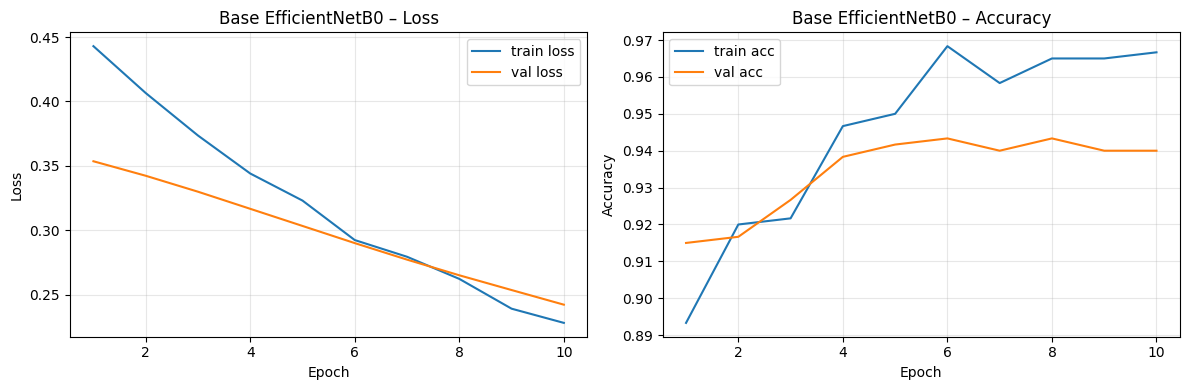

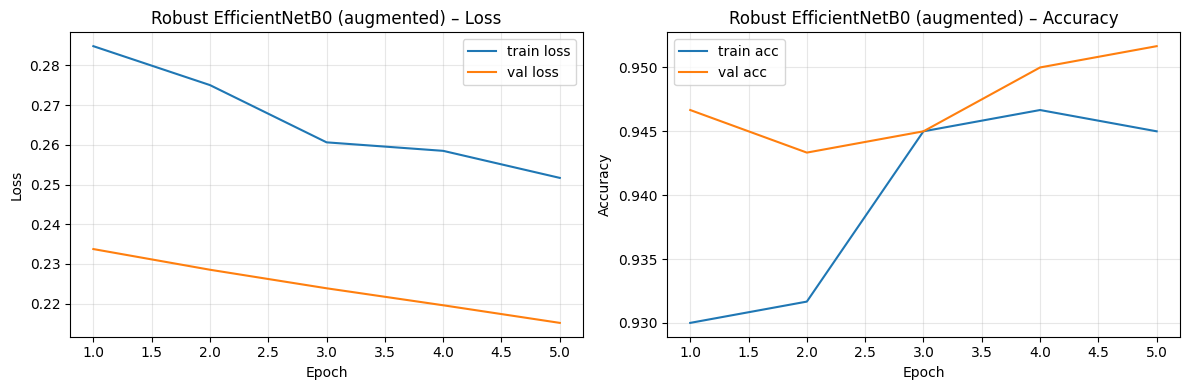

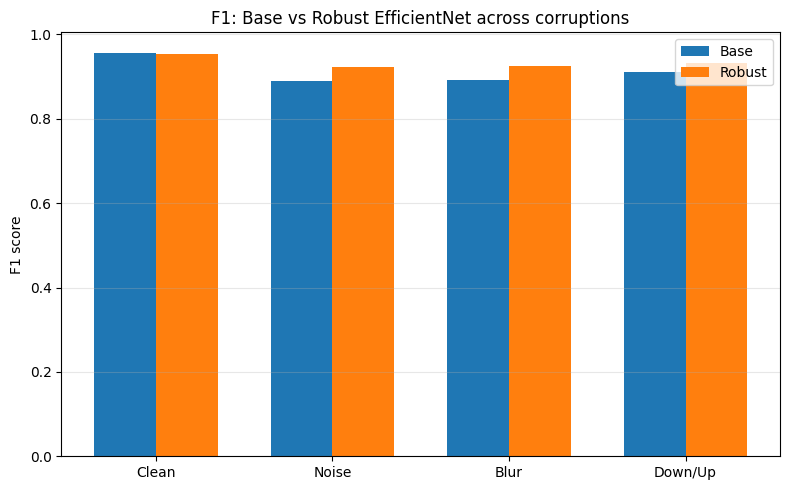

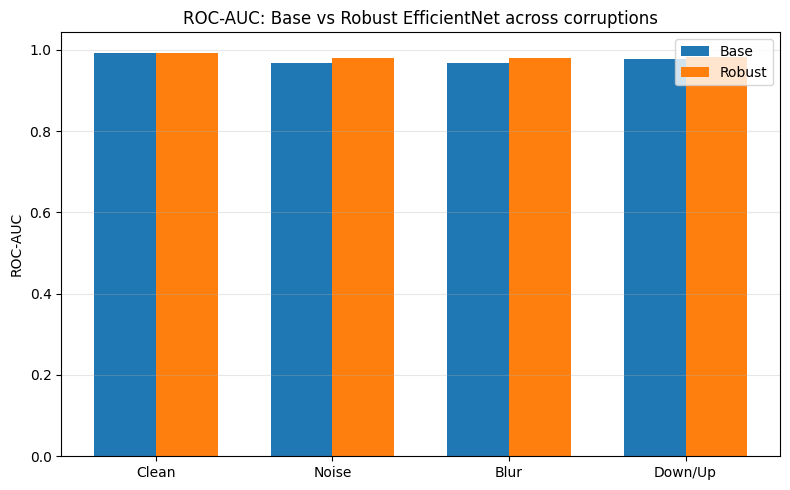

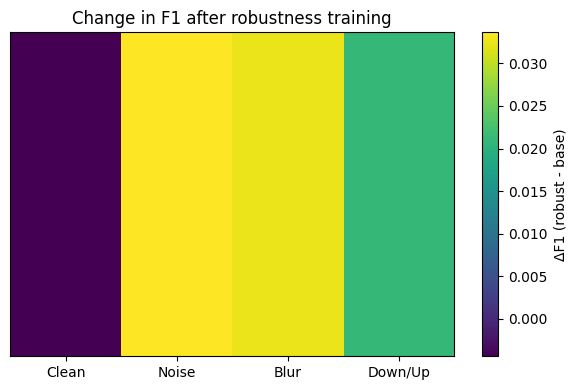

In [31]:
# ============================================================
# 1) TRAINING CURVES – BASE FINE-TUNING VS ROBUST FINE-TUNING
#    (uses `history_ft` and `history_robust`)
# ============================================================

def plot_training_history(history, title_prefix):
    """Plot loss and accuracy for a single Keras History."""
    hist = history.history
    epochs = np.arange(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["loss"], label="train loss")
    if "val_loss" in hist:
        plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} – Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy
    if "accuracy" in hist:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, hist["accuracy"], label="train acc")
        if "val_accuracy" in hist:
            plt.plot(epochs, hist["val_accuracy"], label="val acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{title_prefix} – Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"./results/{title_prefix}_training_history.png")
    plt.show()


# Base EfficientNet fine-tuning (phase 2)
plot_training_history(history_ft, "Base EfficientNetB0")

# Robustness fine-tuning
plot_training_history(history_robust, "Robust EfficientNetB0 (augmented)")


# ============================================================
# 2) GROUPED BAR CHART – F1 FOR BASE VS ROBUST ACROSS CORRUPTIONS
#    (uses `results` dict we built earlier)
# ============================================================

corruptions = ["clean", "noise", "blur", "downup"]
x = np.arange(len(corruptions))  # positions
width = 0.35                     # bar width

base_f1 = [results[f"base_{c}"]["f1"]   for c in corruptions]
rob_f1  = [results[f"robust_{c}"]["f1"] for c in corruptions]

plt.figure(figsize=(8, 5))
plt.bar(x - width / 2, base_f1,  width, label="Base")
plt.bar(x + width / 2, rob_f1,   width, label="Robust")

plt.xticks(x, ["Clean", "Noise", "Blur", "Down/Up"])
plt.ylabel("F1 score")
plt.title("F1: Base vs Robust EfficientNet across corruptions")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("./results/f1_comparison.png")
plt.show()


# ============================================================
# 3) GROUPED BAR CHART – ROC-AUC FOR BASE VS ROBUST
# ============================================================

base_auc = [results[f"base_{c}"]["roc_auc"]   for c in corruptions]
rob_auc  = [results[f"robust_{c}"]["roc_auc"] for c in corruptions]

plt.figure(figsize=(8, 5))
plt.bar(x - width / 2, base_auc, width, label="Base")
plt.bar(x + width / 2, rob_auc,  width, label="Robust")

plt.xticks(x, ["Clean", "Noise", "Blur", "Down/Up"])
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC: Base vs Robust EfficientNet across corruptions")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("./results/roc_auc_comparison.png")
plt.show()


# ============================================================
# 4) HEATMAP-STYLE VIEW – ΔF1 IMPROVEMENT (ROBUST – BASE)
# ============================================================

delta_f1 = np.array(rob_f1) - np.array(base_f1)

plt.figure(figsize=(6, 4))
plt.imshow(delta_f1[None, :], aspect="auto")
plt.colorbar(label="ΔF1 (robust - base)")
plt.yticks([])  # single row
plt.xticks(np.arange(len(corruptions)), ["Clean", "Noise", "Blur", "Down/Up"])
plt.title("Change in F1 after robustness training")
plt.tight_layout()
plt.savefig("./results/delta_f1_improvement.png")
plt.show()